Forklar at vi bliver nødt til at have objective til biomasse og bagefter 'force' fluxen for progesteron til noget bestemt. Så det er ikke 100p troværdigt fordi at progesteron ikke falder til sidst med biomassen. 

## Dynamic Flux Based Analysis

Calculating a single number for the progesterone yield and flux - as we mostly do during this report - gives little information about what the final titres will be. 
To get a better idea of how the progesterone and biomass titres change over time, it can be insightful to mimick real conditions by simulating a simple batch fermentation. This is the purpose of Dynamic Flux Based Analysis (DFBA)

We used cobra and dfba packages to make a DFBA and simulate a batch fermentation in defined intitial conditions.

In [1]:
# Load libraries
from cobra.io import read_sbml_model
from dfba.plot.matplotlib import *
from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [2]:
# Loading model
infilename = '../../models/iMM904_progesterone.xml'
print(f"Loading {infilename}")
model = read_sbml_model(infilename)

Loading ../../models/iMM904_progesterone.xml


In [3]:
model.metabolites.sql_c

Metabolite identifier,sql_c
Name,Squalene C30H50
Memory address,0x07fa5ca6a0ed0
Formula,C30H50
Compartment,c
In 2 reaction(s),"SQLter, SQLS"


In [4]:
model.reactions.SQLS

Reaction identifier,SQLS
Name,Squalene synthase
Memory address,0x07fa5c15ea3d0
Stoichiometry,2.0 frdp_c + h_c + nadph_c --> nadp_c + 2.0 ppi_c + sql_c 2.0 Farnesyl diphosphate + H+ + Nicotinamide adenine dinucleotide phosphate - reduced --> Nicotinamide adenine dinucleotide phosphate + 2.0 Diphosphate + Squalene C30H50
GPR,YHR190W
Lower bound,0.0
Upper bound,999999.0


To ensure that our strain can grow while producing progesterone, we find the optimal progesterone productivity and growth rate (see 03_maximum theoretical yield). To simulate the optimal model in steady state, we define a progesterone productivity from the obtained results:

In [5]:
# max growth rate and max progesterone productivity
with model:
    baseline_max_growth = model.optimize().objective_value
    model.objective = model.reactions.SQLS
    baseline_max_production = model.optimize().objective_value
print(f"Maximum growth rate: {baseline_max_growth} gDW/h")
print(f"Maximum sqr production: {baseline_max_production} mmol/gDW*h")

Maximum growth rate: 0.287865703704015 gDW/h
Maximum sqr production: 0.45769764216366254 mmol/gDW*h


In [6]:
# growth and progesterone productivity when both are set to be objective
with model:
    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
                    model.reactions.get_by_id('SQLS'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    growth = solution.fluxes['BIOMASS_SC5_notrace']
    progesterone = solution.fluxes['SQLS']
    o_uptake = solution.fluxes['EX_o2_e']
    glc_uptake = solution.fluxes['EX_glc__D_e']
    print(f"Growth rate in complete model: {growth} gDW/h")
    print(f"Progesterone productivity in complete model: {progesterone} mmol/gDW*h")
    print(f"oxygen uptake: {o_uptake}")
    print(f"glc uptake: {glc_uptake}")

Growth rate in complete model: 0.21963704713440324 gDW/h
Progesterone productivity in complete model: 0.12554955278174207 mmol/gDW*h
oxygen uptake: -2.0
glc uptake: -10.0


In [7]:
# Setting progesterone productivity constant
# progesterone_gh = progesterone * 1000 / 314.46 # calculate progesterone productivity in g/gDW*h
# print(f"Optimal progesterone production: {progesterone_gh} g/gDW*h")
# progesterone_gh = baseline_max_production * 1000 / 314.46 # calculate progesterone productivity in g/gDW*h
# print(f"Theoretical max progesterone production: {progesterone_gh} g/gDW*h")
# progesterone_gh = 0.225 * 1000 / 314.46 # calculate progesterone productivity in g/gDW*h

model.objective = model.reactions.BIOMASS_SC5_notrace
model.reactions.SQLS.lower_bound = progesterone
print(f"Setting progesterone as objective and biomass production to: {progesterone} g/gDW*h")
#model.reactions.DM_progesterone_c.lower_bound = progesterone_gh

Setting progesterone as objective and biomass production to: 0.12554955278174207 g/gDW*h


In [8]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [9]:
# instances of KineticVariable
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Sqr = KineticVariable("Squalene")
Oxy = KineticVariable("Oxygen")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Sqr, Oxy])

In [10]:
# instances of ExchangeFlux

mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("SQLS")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [11]:
# add rhs expressions for kinetic variables in dfba_model
#ENHEDER?
Vgmax = 8.5
Kg = 0.5
Gin = 100.0
Vomax = 8.0

#This is flux terms:
#dfba_model.add_rhs_expression("Volume", D)
dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X )#* 180.1559 / 1000 ) #+ D * (Gin - Gluc) / V
dfba_model.add_rhs_expression("Squalene", v_P * X)#* 314.46 / 1000 ) # - D * Pro / V

In [12]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

#Oxy = 2
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

In [13]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (mmol/L)

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05,
        "Glucose": 10.0,
        "Squalene": 0, 
        "Oxygen": 2
    }
)

In [14]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "SQLR", "EX_o2_e"])

Ignoring reaction SQLR since it does not correspondto a reaction in the model.
cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 28
Number of residual evaluations     = 100
Number of Jacobian evaluations     = 16
Number of nonlinear iterations     = 48
Number of error test failures      = 5
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 80


Final Run Statistics: 

Number of steps                    = 2
Number of residual evaluations     = 6
Number of Jacobian evaluations     = 1
Number of nonlinear iterations     = 3
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 12


Final Run Statistics: 

Number of steps                    = 25
Number of residual evaluations     = 66
Number of Jacobian evaluations     = 9
Number of nonlinear iterations     = 33
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 45


Final Run Statistics: 

Number of steps                    = 1
Number of residual evaluati

ValueError: 9 columns passed, passed data had 8 columns

In [ ]:
# plotting concentration in steady state
plot_concentrations(concentrations)
plt.title(" \n Batch fermentation simulation \n", size=15)

NameError: name 'concentrations' is not defined

In [ ]:
# printing concentrations in steady state
concentrations

,time,Biomass,Glucose,Oxygen,Progesterone
0,0.0,0.050000,10.000000,2.0,0.000000
1,0.1,0.050597,9.959286,2.0,0.003113
2,0.2,0.051201,9.918093,2.0,0.006263
3,0.3,0.051813,9.876413,2.0,0.009451
4,0.4,0.052432,9.834243,2.0,0.012676
...,...,...,...,...,...
121,12.1,0.210631,0.285111,2.0,0.773832
122,12.2,0.213146,0.224504,2.0,0.777595
123,12.3,0.215694,0.173459,2.0,0.780256
124,12.4,0.218271,0.130923,2.0,0.781935


In [ ]:
0.61/1000 * 314.46   # mol/L * g/mol = g/L

0.19182059999999998

As seen in the figure and table above, the batch fermentaiton ran for 7.8 hours before all of the glucose was consumed. The final progesterone titre reached 0.61 mmol/L (corresponding to 0.19 g/L)
The biomass reached 0.33 gDW.

Text(0.5, 1.0, '\n Fluxes for batch fermentation simulation \n')

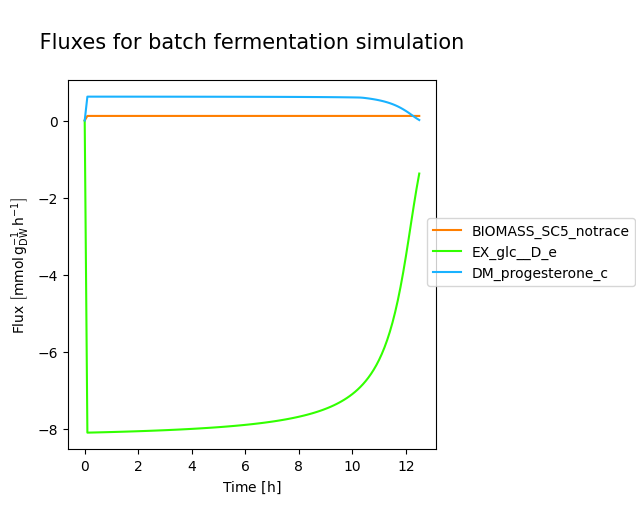

In [ ]:
# Plotting fluxes at steady state
plot_trajectories(trajectories)
plt.title("\n Fluxes for batch fermentation simulation \n", size=15)

In [ ]:
model.metabolites.cit_c

Metabolite identifier,cit_c
Name,Citrate
Memory address,0x07fef8e824790
Formula,C6H5O7
Compartment,c
In 7 reaction(s),"CITtcp, CITtam, CITtap, CITtbm, ACONT, CITtcm, CITt2r"


In [ ]:
model.metabolites.accoa_c

Metabolite identifier,accoa_c
Name,Acetyl-CoA
Memory address,0x07fef8e8dbad0
Formula,C23H34N7O17P3S
Compartment,c
In 23 reaction(s),"HSERTA, MALS, ACCOAtn, IPPS, OHACT2, ACOATA, HMGCOAS, OHACT3, SPMDAT1, OHACT1, ACS, ACACT1r, SERAT, OHACT4, PEPAT, FAS80COA_L, DIAT, OHACT5, FAS80_L, ACGAM6PS, ACCOAC, GLYAT, CSNATr"


In [ ]:
model.metabolites.cit_c


Metabolite identifier,cit_c
Name,Citrate
Memory address,0x07fef8e824790
Formula,C6H5O7
Compartment,c
In 7 reaction(s),"CITtcp, CITtam, CITtap, CITtbm, ACONT, CITtcm, CITt2r"


In [ ]:
model.metabolites.accoa_c

In [ ]:
for reac in model.metabolites.accoa_c.reactions:
    print(reac,"|",reac.flux)

HSERTA: accoa_c + hom__L_c <=> achms_c + coa_c | 0.006802823460445801
MALS: accoa_c + glx_c + h2o_c --> coa_c + h_c + mal__L_c | 0.0
ACCOAtn: accoa_c <=> accoa_n | 0.0
IPPS: 3mob_c + accoa_c + h2o_c --> 3c3hmp_c + coa_c + h_c | -5.85436729397935e-13
OHACT2: accoa_c + iamoh_c --> coa_c + iamac_c | 0.0
ACOATA: ACP_c + accoa_c <=> acACP_c + coa_c | 0.0
HMGCOAS: coa_c + h_c + hmgcoa_c <=> aacoa_c + accoa_c + h2o_c | 0.0
OHACT3: 2mbtoh_c + accoa_c --> 2mbac_c + coa_c | 0.0
SPMDAT1: accoa_c + spmd_c --> N1aspmd_c + coa_c + h_c | 0.0
OHACT1: accoa_c + etoh_c --> aces_c + coa_c | 0.0
ACS: ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c | 0.06065554111532661
ACACT1r: 2.0 accoa_c --> aacoa_c + coa_c | 0.0
SERAT: accoa_c + ser__L_c --> acser_c + coa_c | 0.0
OHACT4: accoa_c + ibutoh_c --> coa_c + ibutac_c | 0.0
PEPAT: accoa_c + pepd_c --> apep_c + coa_c + h_c | 0.0
FAS80COA_L: accoa_c + 9.0 h_c + 3.0 malcoa_c + 6.0 nadph_c --> 3.0 co2_c + 3.0 coa_c + 3.0 h2o_c + 6.0 nadp_c + occoa_c | 0.006648483

In [ ]:
# printing fluxes at steady state
trajectories

,time,BIOMASS_SC5_notrace,EX_glc__D_e,DM_progesterone_c
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.118723,-8.093663,0.618862
2,0.2,0.118723,-8.092056,0.618830
3,0.3,0.118723,-8.090417,0.618798
4,0.4,0.118723,-8.088746,0.618765
...,...,...,...,...
121,12.1,0.118723,-3.086751,0.202349
122,12.2,0.118723,-2.633917,0.152437
123,12.3,0.118723,-2.189297,0.102941
124,12.4,0.118723,-1.763837,0.055579


In this simulation, the fluxes changes rapidly in the beginning, representing the speed of which glucose is consumed while biomass and progesterone is produced. The negative value for glucose means that it is removed from the media when it is consumed by *S. cerevisiae*. In constrast, the positive values for biomass and progesterone means that it is produced. 

When glucose starts to become limited after 5 hours, the glucose flux increases, i.e. it is consumed at a lower rate. It doesn't seem to affect the growth until after approximately 7 hours. 

Progesterone is produced at low levels with a constant flux of approximately 0.5. **WHY** **Fordi den er defineret til det. Så man kan sige at vi kun kan regne med plottet så længe der er steady state. Altså growth rate er konstant**